Step 1 : Reading and Understanding Data

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering》
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Reading the data on which analysis needs to be done

retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# shape of df

retail.shape

(541909, 8)

In [5]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
# df description

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Step 2 : Data Cleaning

In [7]:
# Calculating the Missing Values % contribution in DF

df_null = round((100*retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [8]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [9]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

Step 3 : Data Preparation

In [10]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()  #after grouped,reset the order of the index
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [11]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [12]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [13]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [14]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [16]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [17]:
# Merging the two dfs

rfm = pd.merge(rfm_p, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Diff,Frequency
0,12346.0,325,2
1,12347.0,1,182
2,12348.0,74,31
3,12349.0,18,73
4,12350.0,309,17


In [18]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_m, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Amount']
rfm.head()

,CustomerID,Recency,Frequency,Amount
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40


Rescaling the Attributes
It is extremely important to rescale the variables so that they have a comparable scale.| There are two common ways of rescaling:
(1)Min-Max scaling
(2)Standardisation (mean-0, sigma-1)

In [19]:
# Rescaling the attributes

rfm_df = rfm[['Recency', 'Frequency', 'Amount']]

# Instantiate
Sscaler = StandardScaler()

# fit_transform
rfm_df_Sscaled = Sscaler.fit_transform(rfm_df)
rfm_df_Sscaled.shape

(4372, 3)

In [20]:
# Rescaling the attributes

rfm_df = rfm[['Recency', 'Frequency', 'Amount']]

# Instantiate
MMscaler = MinMaxScaler()

# fit_transform
rfm_df_MMscaled = MMscaler.fit_transform(rfm_df)
rfm_df_MMscaled.shape

(4372, 3)

In [21]:
rfm_df_MMscaled = pd.DataFrame(rfm_df_MMscaled)
rfm_df_MMscaled.columns = ['MMscaledRecency', 'MMscaledFrequency', 'MMscaledAmount']
rfm_df_MMscaled.head()

,MMscaledRecency,MMscaledFrequency,MMscaledAmount
0,0.871314,0.000125,0.015109
1,0.002681,0.022676,0.030297
2,0.198391,0.003758,0.021442
3,0.048257,0.009020,0.021303
4,0.828418,0.002005,0.016288


In [22]:
# assign the label
rfm['MMscaledRecency'] = rfm_df_MMscaled['MMscaledRecency']
rfm['MMscaledFrequency'] = rfm_df_MMscaled['MMscaledFrequency']
rfm['MMscaledAmount'] = rfm_df_MMscaled['MMscaledAmount']
rfm.head()

,CustomerID,Recency,Frequency,Amount,MMscaledRecency,MMscaledFrequency,MMscaledAmount
0,12346.0,325,2,0.00,0.871314,0.000125,0.015109
1,12347.0,1,182,4310.00,0.002681,0.022676,0.030297
2,12348.0,74,31,1797.24,0.198391,0.003758,0.021442
3,12349.0,18,73,1757.55,0.048257,0.009020,0.021303
4,12350.0,309,17,334.40,0.828418,0.002005,0.016288


In [23]:
rfm_df_Sscaled = pd.DataFrame(rfm_df_Sscaled)
rfm_df_Sscaled.columns = ['SscaledRecency', 'SscaledFrequency', 'SscaledAmount']
rfm_df_Sscaled.head()

,SscaledRecency,SscaledFrequency,SscaledAmount
0,2.322023,-0.391720,-0.231001
1,-0.893733,0.382657,0.293432
2,-0.169196,-0.266959,-0.012316
3,-0.725005,-0.086271,-0.017146
4,2.163220,-0.327188,-0.190312


Step 4 : Building the Model

In [24]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_MMscaled)

KMeans(max_iter=50, n_clusters=4)

In [25]:
kmeans.labels_

array([1, 0, 3, ..., 0, 0, 0])

Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

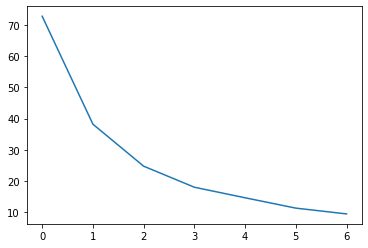

In [26]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_MMscaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

Silhouette Analysis
silhouette score=(p−q)/max(p,q)
 
p  is the mean distance to the points in the nearest cluster that the data point is not a part of

q  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [27]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_MMscaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_MMscaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.7277517120020186
For n_clusters=3, the silhouette score is 0.6570112841149758
For n_clusters=4, the silhouette score is 0.5794718614919225
For n_clusters=5, the silhouette score is 0.5689292348145171
For n_clusters=6, the silhouette score is 0.5801831604587486
For n_clusters=7, the silhouette score is 0.5612928713944579
For n_clusters=8, the silhouette score is 0.4977128391390422


In [28]:
# Final model with k=2
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(rfm_df_MMscaled)

KMeans(max_iter=50, n_clusters=2)

In [29]:
 kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [30]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Recency,Frequency,Amount,MMscaledRecency,MMscaledFrequency,MMscaledAmount,Cluster_Id
0,12346.0,325,2,0.00,0.871314,0.000125,0.015109,1
1,12347.0,1,182,4310.00,0.002681,0.022676,0.030297,0
2,12348.0,74,31,1797.24,0.198391,0.003758,0.021442,0
3,12349.0,18,73,1757.55,0.048257,0.009020,0.021303,0
4,12350.0,309,17,334.40,0.828418,0.002005,0.016288,1


In [31]:
rawDM = pd.DataFrame([
        [1.0, 1.0/5, 1.0/7],
        [5.0, 1.0, 1.0/3],
        [7.0, 3.0, 1.0]
    ], 
    columns=['r','f','m'])
rawDM

,r,f,m
0,1.0,0.2,0.142857
1,5.0,1.0,0.333333
2,7.0,3.0,1.000000


In [32]:
rawDM.loc[0]

r    1.000000
f    0.200000
m    0.142857
Name: 0, dtype: float64

In [33]:
rawDM.sum(axis=0)

r    13.00000
f     4.20000
m     1.47619
dtype: float64

In [34]:
normalizedDM = pd.DataFrame([
        [1.0, 1.0/5, 1.0/7],
        [5.0, 1.0, 1.0/3],
        [7.0, 3.0, 1.0]
    ], 
    columns=['r','f','m'])

normalizedDM['r']= normalizedDM['r']/rawDM.sum(axis=0)[0]
normalizedDM['f']= normalizedDM['f']/rawDM.sum(axis=0)[1]
normalizedDM['m']= normalizedDM['m']/rawDM.sum(axis=0)[2]

In [35]:
normalizedDM

,r,f,m
0,0.076923,0.047619,0.096774
1,0.384615,0.238095,0.225806
2,0.538462,0.714286,0.677419


In [36]:
criteriaDouble = pd.DataFrame([normalizedDM.mean(axis=1)[0],normalizedDM.mean(axis=1)[1],normalizedDM.mean(axis=1)[2]], columns=['weight'])
criteriaDouble

,weight
0,0.073772
1,0.282839
2,0.643389


In [37]:
criteriaDouble.sort_index(axis=0, ascending=True)

,weight
0,0.073772
1,0.282839
2,0.643389


In [38]:
rfmahp = rfm_df_MMscaled

In [39]:
rfmahp

,MMscaledRecency,MMscaledFrequency,MMscaledAmount
0,0.871314,0.000125,0.015109
1,0.002681,0.022676,0.030297
2,0.198391,0.003758,0.021442
3,0.048257,0.009020,0.021303
4,0.828418,0.002005,0.016288
...,...,...,...
4367,0.742627,0.001128,0.015746
4368,0.482574,0.000752,0.015394
4369,0.018767,0.001503,0.015731
4370,0.008043,0.094588,0.022491


In [40]:
for i in range(rfm_df_MMscaled.shape[0]):
    rfmahp.loc[i][0] = rfm_df_MMscaled.loc[i][0] * criteriaDouble.loc[0]
    rfmahp.loc[i][1] = rfm_df_MMscaled.loc[i][1] * criteriaDouble.loc[1]
    rfmahp.loc[i][2] = rfm_df_MMscaled.loc[i][2] * criteriaDouble.loc[2]

In [41]:
rfmahp

,MMscaledRecency,MMscaledFrequency,MMscaledAmount
0,0.064279,0.000035,0.009721
1,0.000198,0.006414,0.019493
2,0.014636,0.001063,0.013796
3,0.003560,0.002551,0.013706
4,0.061114,0.000567,0.010479
...,...,...,...
4367,0.054785,0.000319,0.010131
4368,0.035600,0.000213,0.009904
4369,0.001384,0.000425,0.010121
4370,0.000593,0.026753,0.014471


In [42]:
rfm['AHPScore'] = rfmahp.sum(axis = 1)
rfm.head()

,CustomerID,Recency,Frequency,Amount,MMscaledRecency,MMscaledFrequency,MMscaledAmount,Cluster_Id,AHPScore
0,12346.0,325,2,0.00,0.871314,0.000125,0.015109,1,0.074035
1,12347.0,1,182,4310.00,0.002681,0.022676,0.030297,0,0.026104
2,12348.0,74,31,1797.24,0.198391,0.003758,0.021442,0,0.029495
3,12349.0,18,73,1757.55,0.048257,0.009020,0.021303,0,0.019817
4,12350.0,309,17,334.40,0.828418,0.002005,0.016288,1,0.072160


In [43]:
cluster_0 = rfm[rfm['Cluster_Id'] == 0]
cluster0=cluster_0.sort_values(by='AHPScore',ascending=False)
cluster0 = cluster0.reset_index()
cluster0

,index,CustomerID,Recency,Frequency,Amount,MMscaledRecency,MMscaledFrequency,MMscaledAmount,Cluster_Id,AHPScore
0,1703,14646.0,1,2085,279489.02,0.002681,0.261087,1.000000,0,0.717432
1,4233,18102.0,0,433,256438.49,0.000000,0.054122,0.918772,0,0.606436
2,1895,14911.0,0,5903,132572.62,0.000000,0.739414,0.482282,0,0.519430
3,3758,17450.0,7,351,187482.17,0.018767,0.043849,0.675777,0,0.448574
4,4042,17841.0,1,7983,40340.78,0.002681,1.000000,0.157266,0,0.384220
...,...,...,...,...,...,...,...,...,...,...
3285,3120,16569.0,2,5,124.20,0.005362,0.000501,0.015547,0,0.010540
3286,2693,15992.0,3,3,41.99,0.008043,0.000251,0.015257,0,0.010480
3287,4362,18273.0,1,3,204.00,0.002681,0.000251,0.015828,0,0.010452
3288,1799,14777.0,3,3,-17.45,0.008043,0.000251,0.015048,0,0.010346


In [44]:
cluster_1 = rfm[rfm['Cluster_Id'] == 1]
cluster1=cluster_1.sort_values(by='AHPScore',ascending=False)
cluster1 = cluster1.reset_index()
cluster1

,index,CustomerID,Recency,Frequency,Amount,MMscaledRecency,MMscaledFrequency,MMscaledAmount,Cluster_Id,AHPScore
0,2522,15749.0,234,15,21535.90,0.627346,0.001754,0.090999,1,0.105325
1,4048,17850.0,301,312,5288.63,0.806971,0.038963,0.033746,1,0.092264
2,3256,16754.0,371,2,2002.40,0.994638,0.000125,0.022165,1,0.087673
3,4140,17968.0,373,85,277.35,1.000000,0.010524,0.016087,1,0.087099
4,2619,15880.0,368,106,313.28,0.986595,0.013155,0.016213,1,0.086935
...,...,...,...,...,...,...,...,...,...,...
1077,3750,17440.0,147,8,177.10,0.394102,0.000877,0.015733,1,0.039444
1078,4124,17948.0,146,1,358.56,0.391421,0.000000,0.016373,1,0.039410
1079,2152,15256.0,148,6,98.45,0.396783,0.000626,0.015456,1,0.039393
1080,1205,13967.0,145,2,80.70,0.388740,0.000125,0.015394,1,0.038618


In [45]:
cluster0.to_csv('C:\\Users\\user\\Desktop\\课程material\\IS6400\\project\\cluster_0.csv')
cluster1.to_csv('C:\\Users\\user\\Desktop\\课程material\\IS6400\\project\\cluster_1.csv')